# Cat vs Non-cat Classification

Using a Deep Feedforward Neural Network for classifying cats vs non-cats.

_PyTorch implementation of the assignment of Course 1 of Coursera's Deep Learning Specialization_.

## Imports

In [1]:
%matplotlib inline

import h5py
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils

from torch.utils.data import DataLoader, Dataset

## Reproducibility

In [2]:
seed = 24
random.seed(seed)
torch.manual_seed(seed);

## Device Configuration

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Dataset

We will create a custom dataset that can load the images from the given `.h5` files. The files contain:

- 209 training examples
- 50 testing examples
- each image is of size: (64, 64, 3)

In [4]:
class CatsDataset(Dataset):
    def __init__(self, train, transform=None):
        prefix = 'train' if train else 'test'
        dataset = h5py.File(f'data/{prefix}_catvnoncat.h5', 'r')

        self.X = np.array(dataset[f'{prefix}_set_x'][:])
        # Reshape target values to be of shape (sample_size, 1)
        self.y = np.array(dataset[f'{prefix}_set_y'][:]).reshape(self.X.shape[0], 1)
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        X = self.transform(self.X[idx, :]) if self.transform else self.X[idx, :]
        # Convert the targets to a float tensor
        # This is needed to compute the loss which requires both outputs and targets to be the same type
        y = torch.from_numpy(self.y[idx, :]).float() 
        
        return X, y

We can now create training and test sets. We use `ToTensor()` to convert the images to a PyTorch tensor with shape channels x height x width, and with pixel values rescaled from [0, 255] to [0, 1].

In [5]:
training = DataLoader(CatsDataset(train=True, transform=transforms.ToTensor()), batch_size=64, shuffle=True, num_workers=4)
testing = DataLoader(CatsDataset(train=False, transform=transforms.ToTensor()), batch_size=64, shuffle=True, num_workers=4)

Let's look at some examples from the training set.

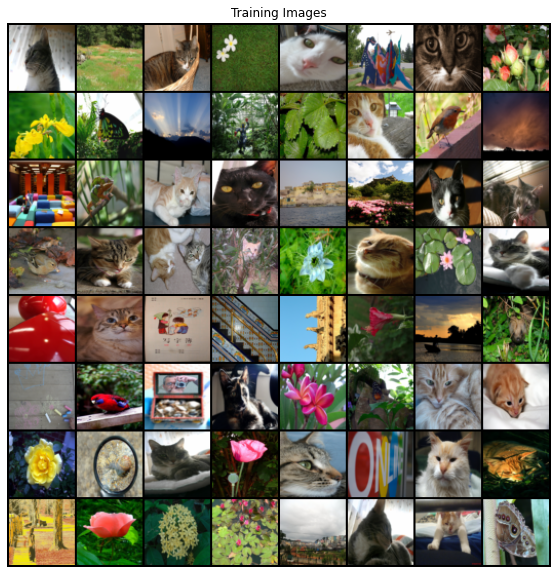

In [6]:
batch = next(iter(training))
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.title('Training Images')
# We need to swap the axes to (height, width, channels) for matplotlib to plot the image correctly
plt.imshow(np.transpose(vutils.make_grid(batch[0], padding=2, normalize=True), (1, 2, 0)));

## Model

We'll use a Deep Feedforward Neural Network as follows:

- Flatten Layer: Convert the 3 x 64 x 64 images into vectors of size 12,288
- Hidden Layer 1: Linear -> ReLU with 20 units
- Hidden Layer 2: Linear -> ReLU with 7 units
- Hidden Layer 3: Linear -> ReLU with 5 units
- Output Layer: Linear -> Sigmoid with 1 unit

In [7]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.net = nn.Sequential(
            nn.Flatten(),
            # Hidden Layer 1
            nn.Linear(in_features=12288, out_features=20),
            nn.ReLU(inplace=True),
            # Hidden Layer 2
            nn.Linear(in_features=20, out_features=7),
            nn.ReLU(inplace=True),
            # Hidden Layer 3
            nn.Linear(in_features=7, out_features=5),
            nn.ReLU(inplace=True),
            # Output layer
            nn.Linear(in_features=5, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.net(input)

In [8]:
model = Model()
print(model)

Model(
  (net): Sequential(
    (0): Flatten()
    (1): Linear(in_features=12288, out_features=20, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=20, out_features=7, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=7, out_features=5, bias=True)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=5, out_features=1, bias=True)
    (8): Sigmoid()
  )
)


## Optimization

We'll use Stochastic Gradient Descent for training the model with the binary cross-entropy loss.

In [9]:
loss_fn = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0075)

## Training

Time to train the model!

In [10]:
# Training configuration
epochs = 1000

[0/1000]	Loss: 0.6565143465995789
[100/1000]	Loss: 0.6517608165740967
[200/1000]	Loss: 0.6335422992706299
[300/1000]	Loss: 0.5567355155944824
[400/1000]	Loss: 0.3735312223434448
[500/1000]	Loss: 0.4423926770687103
[600/1000]	Loss: 0.08613965660333633
[700/1000]	Loss: 0.024906979873776436
[800/1000]	Loss: 0.011013872921466827
[900/1000]	Loss: 0.0062109846621751785


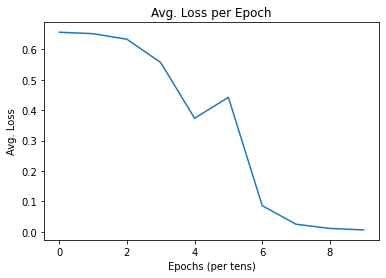

In [11]:
# Main training loop
model = model.to(device)
total_losses = []

for epoch in range(epochs):
    losses = []

    for samples, targets in training:
        optimizer.zero_grad()
        samples = samples.to(device)
        targets = targets.to(device)

        output = model(samples)
        loss = loss_fn(output, targets)

        loss.backward()
        optimizer.step()
        
        # Detach the loss to avoid saving any more computations on it
        losses.append(loss.detach().cpu().numpy())

    if epoch % 100 == 0:
        total_losses.append(np.mean(losses))
        print(f'[{epoch}/{epochs}]\tLoss: {total_losses[-1]}')

# Save the model
torch.save(model.state_dict(), 'model/model.pt')

# Plot the losses per tens of epochs
plt.plot(total_losses)
plt.ylabel('Avg. Loss')
plt.xlabel('Epochs (per tens)')
plt.title('Avg. Loss per Epoch')
plt.show()

## Testing

Now that we have trained our model, we can evaluate it against the testing set.

In [12]:
# Load the trained model
model = Model()
model.load_state_dict(torch.load('model/model.pt'))
# Always set the mode to `eval` for inference
model.eval()
model = model.to(device)

accuracies = []
cats = []
non_cats = []

# Main inference loop
for samples, targets in testing:
    output = model(samples.to(device))
    
    samples = samples.detach().cpu().numpy()
    output = output.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    
    # Convert the probabilities into actual classes
    output[output > 0.5] = 1  # cat
    output[output <= 0.5] = 0  # non-cat

    # Remove extra dimension, i.e. flatten as vector
    output = np.squeeze(output)
    targets = np.squeeze(targets)

    # Since now we have actual classes we can evaluate using accuracy
    accuracies.append(np.mean(output == targets))
    
    # Save the cats and the non-cats
    cats.extend(samples[output == 1, :])
    non_cats.extend(samples[output == 0, :])

print(f'Accuracy = {np.mean(accuracies)}')

Accuracy = 0.76


Finally, we can look at the examples that were identified as cats and those that weren't.

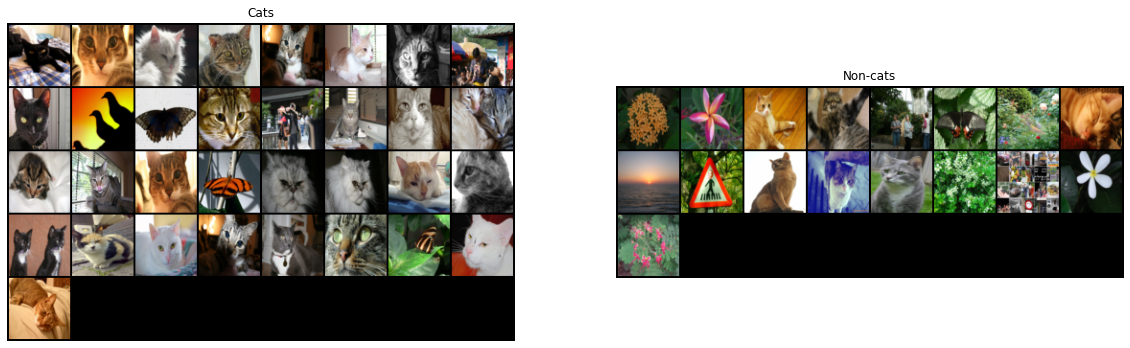

In [13]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Cats')
plt.imshow(np.transpose(vutils.make_grid(torch.from_numpy(np.array(cats)), padding=2, normalize=True), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Non-cats')
plt.imshow(np.transpose(vutils.make_grid(torch.from_numpy(np.array(non_cats)), padding=2, normalize=True), (1, 2, 0)))

plt.show()

Some of the types of examples where the model makes mistakes:

- Classifying butterflies as cats (maybe because of the color?)
- Failing to classify as cats images where the cats are in a weird position or the picture was taken at a weird angle